# Practical Assignment 3

Dennis Verheijden, s4455770 and Joost Besseling, s4756799

In [3]:
from chainer import Chain
import chainer.links as L
from chainer import link
from chainer import reporter
from chainer import Variable
import numpy as np
from chainer import optimizers
from chainer.datasets import TupleDataset
import pickle
import matplotlib.pyplot as plt

For Practical assignment 3 we implemented the Recurrent Neural Network as given below:

In [4]:
class RNN(Chain):
	def __init__(self, n_hidden):
		super(RNN, self).__init__()
		with self.init_scope():
			self.lstm = L.LSTM(None, n_hidden)  # LSTM layer
			self.out = L.Linear(n_hidden, 1)  # feed-forward output layer

	def reset_state(self):
		self.lstm.reset_state()

	def __call__(self, x):
		# transform the input 'x' to a compatible input for an LSTM layer
		x = Variable(np.array([np.float32([x])]))

		l1 = self.lstm(x)
		y = self.out(l1)

		return y


We had to implement a regressor class which could make continuous predictions. We chose to make a general regressor class which takes a loss- and accuracyfunction to respectively computes the loss and accuracy:

In [5]:
class Regressor(Chain):
	"""
	General implementation of a Regressor class
	"""

	compute_accuracy = True

	def __init__(self, predictor, lossfun, accfun):
		"""
		:param predictor: Chain that predicts output given input; the network
		:param lossfun: loss function
		:param accfun: accuracy function
		"""
		super(Regressor, self).__init__()
		self.lossfun = lossfun
		self.accfun = accfun
		self.y = None
		self.loss = None
		self.accuracy = None

		with self.init_scope():
			self.predictor = predictor

	def __call__(self, x, t):
		self.y = None
		self.loss = None
		self.accuracy = None
		self.y = self.predictor(x)
		self.loss = self.lossfun(self.y, t)
		reporter.report({'loss': self.loss}, self)
		if self.compute_accuracy:
			self.accuracy = self.accfun(self.y, t)
			reporter.report({'accuracy': self.accuracy}, self)
		return self.loss


For the loss function we use the mean-squared error. For the accuracy function we use the following:

In [7]:
def compute_loss(y, t):
	"""
	We define the loss as the squared error between the predicted and actual sum
	:param y: predicted sum
	:param t: actual sum
	:return: loss
	"""
	return pow(y - t, 2)


def compute_accuracy(y, t):
	"""
	We define the accuracy as 1 over the distance between the predicted and actual sum
	:param y: predicted sum
	:param t: actual sum
	:return: accuracy
	"""
	return 1 / abs(y - t)


Next, we also had to implement our own iterator that could handle sequential data, as given below:

In [6]:
class StreamingIterator(object):
	"""
    Divides the data into equal sequentions, and shuffles those. 
    To make sure the order of the individual sequences is preserved.
    
    Based on the Iterator from assignment 1
	"""

	def __init__(self, data, batch_size=20):
		"""
		Args:
			data (TupleDataset):
			batch_size (int):

		Returns:
			list of batches consisting of (input, output) pairs
		"""

		self.data = data

		self.batch_size = batch_size
		self.n_batches = len(self.data) // batch_size

	def __iter__(self):
		self.idx = -1
		self._order = np.random.permutation(len(self.data))[:(self.n_batches * self.batch_size)]
		self._data_ = [self.data[x * self.batch_size:(x + 1) * self.batch_size] for x in range(self.n_batches)]
		np.random.shuffle(self._data_)

		return self

	def __next__(self):
		self.idx += 1

		if self.idx == self.n_batches:
			raise StopIteration

		i = self.idx

		return self._data_[i]

	def __len__(self):
		return self.n_batches


The goal of this assignment was to teach a RNN to correctly sum its inputs. The training and test data is generated by the follwing function, given in the assignment:

In [12]:
def create_data(n=3000):
	X = np.random.rand(n, 1).astype('float32')
	T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
	T = np.hstack([0, T[0:]]).astype('float32')
	T = T.reshape([n, 1])

	return TupleDataset(X, T)


Since training the networks takes more and more time every assignment, we decided to save our models when they are trained. Such that they can be reused when needed. This function either retrieves or trains a model and then plots the training and test loss as a function of epochs.

In [9]:
def get_model(model_name):
	"""
	Load the named model if it exists, otherwise train it
    After loading the model, plot the training and test loss as a function of epochs
	:param model_name: Name of the model
	:return: Network, Regressor, Optimizer and results
	"""
	try:
		pickle_in = open("{}_rnn.pickle".format(model_name), 'rb')
		rnn = pickle.load(pickle_in)

		pickle_in = open("{}_model.pickle".format(model_name), 'rb')
		model = pickle.load(pickle_in)

		pickle_in = open("{}_optimizer.pickle".format(model_name), 'rb')
		optimizer = pickle.load(pickle_in)

		pickle_in = open("{}_results.pickle".format(model_name), 'rb')
		results = pickle.load(pickle_in)

		print("Model '{}' Loaded!".format(model_name))

	except FileNotFoundError:
		rnn = RNN(n_hidden=hidden_units)

		model = Regressor(rnn, accfun=compute_accuracy, lossfun=compute_loss)

		# Set up the optimizer
		optimizer = optimizers.SGD()
		optimizer.setup(model)

		print("Model not found! Starting training ...")
		results = train_network(train_iter, rnn, model, optimizer)

		with open('{}_rnn.pickle'.format(model_name), 'wb') as f:
			pickle.dump(rnn, f)
		with open('{}_model.pickle'.format(model_name), 'wb') as f:
			pickle.dump(model, f)
		with open('{}_optimizer.pickle'.format(model_name), 'wb') as f:
			pickle.dump(optimizer, f)
		with open('{}_results.pickle'.format(model_name), 'wb') as f:
			pickle.dump(results, f)

	# Plot the training and test loss as a function of epochs
	plt.plot(results[0], label='train loss')
	plt.plot(results[1], label='test loss')
	plt.legend()
	plt.xlabel("epoch")
	plt.ylabel("loss")
	plt.show()
	return rnn, model, optimizer, results

## Exercise 1

We loop through the sequences of data, as returned by the iterator, and train the network.  For each sequence, we first have to reset the state, to forget the input of the last sequence. Then we train on all numbers in this sequence, trying to predict the sum of the previous two numbers.

Of course, the first number will give weird results, since the sum of 1 number should be that number. This is not the case because we take random sequences from the generated data, this adds some noice, and by taking long enough sequences  the adverse effects on our RNN will be minimized.

In [10]:
def train_network(sample_iter, rnn, model, optimizer):
	"""
	Trains the network for n_epochs.
	One epoch contains of a training phase and testing phase.
	:param sample_iter: training data iterator
	:param rnn:
	:param model:
	:param optimizer:
	:return: average test and training loss per epoch
	"""
	train_loss_list = []
	test_loss_list = []

	for epoch in range(n_epochs):
		print('Epoch {}'.format(epoch + 1))
		current_train_loss = 0
		current_test_loss = 0
		for batch in sample_iter:
			rnn.reset_state()  # new batch -> reset states
			train_loss, train_accuracy = feed_data(batch, model, optimizer, True)
			test_loss, test_accuracy = feed_data(batch, model, optimizer, False)

			current_train_loss += train_loss
			current_test_loss += test_loss
			print("\t Training: accuracy: {} \t loss: {} \n\t Testing: accuracy: {} \t loss: {}".format(
				train_accuracy,
				train_loss,
				test_accuracy,
				test_loss))
		train_loss_list.append(current_train_loss / len(sample_iter))
		test_loss_list.append((current_test_loss / len(sample_iter)))
	return [train_loss_list, test_loss_list]


In [11]:
def feed_data(batch, model, optimizer, update):
	"""
	Feed the data through the network and update the weights if needed
	:param batch: sequential data
	:param model:
	:param optimizer:
	:param update: bool on whether to update the weights
	:return: average loss and accuracy of the batch
	"""
	total_loss = 0
	total_accuracy = 0
	for x, t in batch:
		model(x, t)
		if update:
			optimizer.update(compute_loss, model.y, t)
		total_loss += float(model.loss.data)
		total_accuracy += float(model.accuracy.data)
	return total_loss / len(batch), total_accuracy / len(batch)


Now, to train a RNN, we just have to set the required parameters, retrieve our training data and get our model:

Model 'n_epochs10_batch_size100_train_size1000_hidden_units30' Loaded!


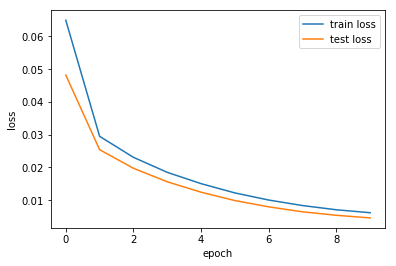

In [13]:
	n_epochs = 10
	batch_size = 100
	train_data_size = 1000
	hidden_units = 30

	train_data = create_data(n=train_data_size)

	train_iter = StreamingIterator(train_data, batch_size=batch_size)

	rnn, model, optimizer, results = get_model("n_epochs{}_batch_size{}_train_size{}_hidden_units{}".format(
		n_epochs,
		batch_size,
		train_data_size,
		hidden_units
	))


We can see that the loss decreases rapidly, especially during the first epochs. And it is also clear that we didn't reach the lowest loss yet, but training the model takes a long time, so we decided to stop after 10 epochs.

## Exercise 2

For the second exercise we had to generate test data and plot the predicted sum and the actual sum as a function of time. We did this by using the following function:

In [15]:
def test_network(sample_iter):
	"""
	Test the network by feeding it the sequential data
	Plot the predicted and actual sum per sample
	Plot the difference between the actual and predicted sum
	:param sample_iter: Test iterator object over test samples
	:return:
	"""
	rnn.reset_state()  # reset internal states
	predicted_sum = []
	actual_sum = []
	for sample in sample_iter:
		for data in sample:
			x, t = data
			model(x, t)
			actual_sum.append(t[0])  # unpack values
			predicted_sum.append(model.y.data[0][0])  # unpack values

	plt.plot(predicted_sum, 'ro', label="predicted sum")
	plt.plot(actual_sum, 'go', label="actual sum")
	plt.xlabel("sample")
	plt.ylabel("output")
	plt.legend()
	plt.show()

	difference = abs(np.subtract(predicted_sum, actual_sum))
	plt.plot(difference)
	plt.xlabel("sample")
	plt.ylabel("prediction error")
	plt.show()


Now we just have to generate the test data and run the function:

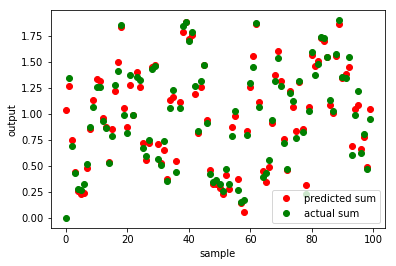

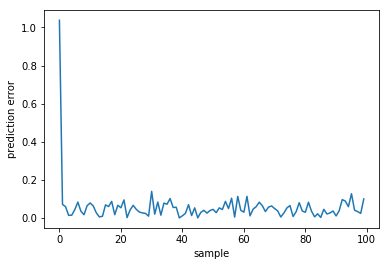

In [17]:
	test_data = create_data(n=100)
	test_iter = StreamingIterator(test_data, batch_size=len(test_data))
	test_network(test_iter)


As can be seen above, the RNN can make accurate predictions about what it should do: sum up it's inputs. As a supporting plot we also plotted the difference between the RNN's prediction and the actual sum. And as can be seen, the predictions are fairly accurate. 

As we alluded to before, the first prediction is totally of, because there is no data available. It is interesting to note that the network predicts around 1, this is around the mean of the data. So it seems like the best prediction without any information.